


### Not Enough DATA


In [1]:
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline


### Let's create some datapoints. Please note the number of majority and minority classes.

In [2]:
num_majority_class=1000
num_minority_class=150

majority_class_flag=-1.0
minority_class_flag=1.0

def generate_data(num_majority_class,num_minority_class):
    np.random.seed(42)
    # multiply by 2 to have higher variance!
    x1=np.random.standard_normal(num_majority_class)*2.0
    x2=np.random.standard_normal(num_majority_class)*2.0
    xdata=pd.DataFrame(data=[x1,x2]).transpose()
    xdata=xdata.rename(index=str, columns={0: "x1", 1: "x2"})
    xdata['category']=majority_class_flag
    xdata.head()

    # you can plaz with this the following way:
    # multiply by a number under 1 to have less variance!
    # multiply by a number above 1 to have more variance!
    x1=np.random.standard_normal(num_minority_class)*1.0+2.5
    x2=np.random.standard_normal(num_minority_class)*1.0+2.5
    y2=np.full(num_minority_class,minority_class_flag)
    cat2=pd.DataFrame(data=[x1,x2,y2]).transpose()
    cat2=cat2.rename(index=str, columns={0: "x1", 1: "x2", 2:"category"})
    xdata=xdata.append(cat2)
    xdata=xdata.reset_index(drop=True)
    return xdata

xdata=generate_data(num_majority_class,num_minority_class)


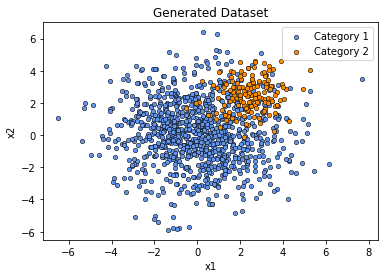

In [3]:

def plot_data_points(plotdatax):
    ax = plotdatax[plotdatax['category']==majority_class_flag].plot.scatter(x="x1",y="x2", color='cornflowerblue',edgecolor='black', linewidth='0.5',marker="o",s=20, label='Category 1');
    plotdatax[plotdatax['category']==minority_class_flag].plot.scatter(x="x1",y="x2", color='darkorange',edgecolor='black', linewidth='0.5', label='Category 2',s=20, ax=ax);
    return ax
plot_data_points(xdata)
plt.title("Generated Dataset")

plt.show()

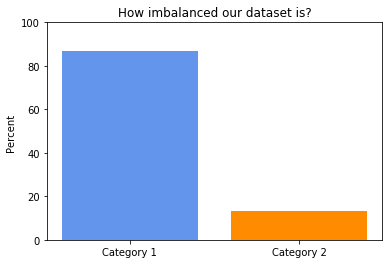

In [4]:

def show_balance_of_classes(xdata):
    total_size=len(xdata)
    size_cat1=len(xdata[xdata['category']==majority_class_flag])
    size_cat2=len(xdata[xdata['category']==minority_class_flag])
    fig, ax = plt.subplots()
    ind = np.arange(1, 3)

    cat1, cat2 = plt.bar(ind, [size_cat1/total_size*100,size_cat2/total_size*100])
    cat1.set_facecolor('cornflowerblue')
    cat2.set_facecolor('darkorange')

    ax.set_xticks(ind)
    ax.set_xticklabels(['Category 1', 'Category 2'])
    ax.set_ylim([0, 100])
    ax.set_ylabel('Percent ')
    ax.set_title('How imbalanced our dataset is?')

    plt.show()
    
show_balance_of_classes(xdata)

### Create Train and Eval set

In [5]:

data=xdata.copy()
y=data.pop('category')
X=data
x_train, x_eval, y_train, y_eval = train_test_split(X,y,test_size=0.3, random_state = 42)
    


## Let's solve this first with Tensorflow and Linear SVM
Lets create the loss function with tensorflow graph so later we can modify it. 


### Create Placeholders and Variables

In [6]:
import tensorflow as tf
tf.reset_default_graph()
ph_xdata = tf.placeholder(shape=[None,2],dtype=tf.float32)
ph_ytrue = tf.placeholder(shape=[None,1],dtype=tf.float32)
ph_weights= tf.placeholder(shape=[None,1],dtype=tf.float32)

#let's set some random init values
W = tf.get_variable("W", dtype=tf.float32,initializer=tf.constant([[23.],[ 42.]]))
b = tf.get_variable("b", dtype=tf.float32,initializer=tf.constant([[5.]]))


### Creating Loss function

SVM uses the Hinge loss, you may remember the Hinge loss is:<br/>
<img src="svm_loss.png"
     alt="svm_loss_info"
/>
<br/>

where<br/>

<img src="svm_loss_info.png"
     alt="svm_loss_info"
     /><br/>

Let's implement this loss with tensorflow:

In [7]:

w_norm=tf.square(tf.norm(W))
alpha=tf.constant([0.1])
C=tf.constant(1.0)

model_output=tf.subtract(tf.matmul(ph_xdata,W),b)
substract_term=tf.subtract(1.0,tf.multiply(model_output,ph_ytrue))

class_term=tf.multiply(C,tf.reduce_mean(tf.maximum(0.0,substract_term)))
hinge_loss_svm=tf.add(class_term,tf.multiply(alpha,w_norm))



### Lets train on our data


In [8]:

def train(loss_candidate,x_train,y_train,x_eval,y_weights=None):
    learning_rate=0.015
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.minimize(loss_candidate)
    # The init is done above, therefore no init needed.
    #init = tf.global_variables_initializer()
    with tf.Session() as sess:

        #sess.run(init)
        sess.run(W.initializer)
        sess.run(b.initializer)

        epochs = 10000
        loss_vec=[]
        for i in range(epochs):
            if(y_weights is None):
                sess.run(train_step,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train]) })
                temp_loss=sess.run(loss_candidate,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train])})
            else:
                sess.run(train_step,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train]),ph_weights:y_weights })
                temp_loss=sess.run(loss_candidate,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train]),ph_weights:y_weights })
            
            loss_vec.append(temp_loss)
            if(i%300==0):
                # Fetch Back Results
                [[a1],[a2]] = sess.run(W)
                [[b1]]  = sess.run(b)
                temp_slope=-a2/a1
                temp_intercept=b1/a1
                print("loss:",temp_loss,"slope:",temp_slope,"intercept:",temp_intercept,"W",a1,a2,"b",b1)

        # Fetch back the results
        [[w1],[w2]] = sess.run(W)
        [[b1]]  = sess.run(b)
        
        eval_predictions=sess.run(model_output,feed_dict={ph_xdata : x_eval})


    final_slope=-w2/w1
    final_intercept=b1/w1
    
    eval_predictions=pd.DataFrame(eval_predictions)[0].apply(lambda x: -1 if x<0 else 1)
    
    #print(eval_predictions)
    print("slope:",final_slope)
    print("intercept:",final_intercept)
    return final_slope,final_intercept,eval_predictions
    
# lets use our predefined hinge loss for the training.
final_slope,final_intercept,eval_predictions=train(hinge_loss_svm,x_train,y_train,x_eval)

loss: [259.58282] slope: -1.8259685 intercept: 0.21836054 W 22.927094 41.86415 b 5.0063725
loss: [39.72075] slope: -1.7630723 intercept: 0.79915774 W 8.540832 15.058104 b 6.8254714
loss: [3.9559975] slope: -1.6092081 intercept: 3.0254376 W 2.714087 4.367531 b 8.211301
loss: [0.79574883] slope: -1.2371881 intercept: 6.6717415 W 1.2451559 1.540492 b 8.307359
loss: [0.72165155] slope: -1.0083681 intercept: 6.295525 W 1.2445856 1.2550005 b 7.83532
loss: [0.668216] slope: -0.9300078 intercept: 5.9765162 W 1.2312164 1.1450409 b 7.358385
loss: [0.619113] slope: -0.88711554 intercept: 5.7349844 W 1.2024338 1.0666977 b 6.8959394
loss: [0.57348347] slope: -0.8726118 intercept: 5.5920105 W 1.1534692 1.0065309 b 6.450212
loss: [0.5316979] slope: -0.86797285 intercept: 5.487397 W 1.0977733 0.9528374 b 6.023918
loss: [0.49422607] slope: -0.8703585 intercept: 5.4582343 W 1.0301932 0.89663744 b 5.623036
loss: [0.46023] slope: -0.85776156 intercept: 5.358073 W 0.97796553 0.8388612 b 5.2400107
loss: [0.

In [9]:

print(classification_report(y_eval, eval_predictions, target_names=['Category 1','Category 2']))


              precision    recall  f1-score   support

  Category 1       0.90      0.99      0.94       307
  Category 2       0.50      0.11      0.17        38

   micro avg       0.89      0.89      0.89       345
   macro avg       0.70      0.55      0.56       345
weighted avg       0.86      0.89      0.86       345



<p style="color:red"> The f1-score, and recall is very low for category 2</p>

#### Conclusion: the algorithm is very bad in recognizing category 2

<br/>

#### Let's draw the decision boundary:

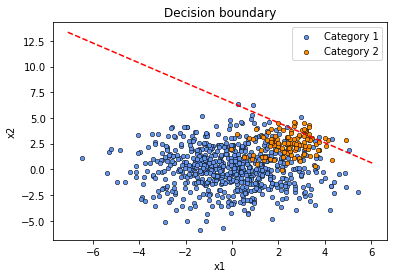

In [10]:
def abline(ax,slope, intercept):
    """Plot a line from slope and intercept"""
    axes = ax#plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color='r')
    axes.set_title("Decision boundary")
    
def show_decision_boundary(final_slope,final_intercept):
    plotdatax=x_train.copy()
    plotdatax['category']=y_train

    ax=plot_data_points(plotdatax)
    abline(ax,final_slope,final_intercept)
    plt.show()

show_decision_boundary(final_slope,final_intercept)

### What to do now? Solution 1: Let's introduce weights for the loss

First we generate some weights

In [11]:
def gen_weights(x,weight):
    if x==minority_class_flag:
        return weight
    else:
        return 1.0
generated_weights=y_train.apply(lambda x:gen_weights(x,2.5))
y_weights=np.transpose([generated_weights])
print("lets look at the head of the weights:")
np.transpose(y_weights[:50])

lets look at the head of the weights:


array([[1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 2.5, 1. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 2.5, 1. , 1. , 1. , 2.5, 1. , 1. , 1. ,
        1. , 1. , 2.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]])

Modify the default loss, multiply with the prepared weights

In [12]:

weighted_class_term=tf.reduce_mean(tf.maximum(0.0,tf.multiply(ph_weights,substract_term)))
weighted_loss_svm=tf.add(weighted_class_term,tf.multiply(alpha,w_norm))


Train with the new weighted loss function:

In [13]:
final_slope,final_intercept,eval_predictions=train(weighted_loss_svm,x_train,y_train,x_eval,y_weights)

loss: [259.58282] slope: -1.8259685 intercept: 0.21836054 W 22.927094 41.86415 b 5.0063725
loss: [39.72075] slope: -1.7630723 intercept: 0.79915774 W 8.540832 15.058104 b 6.8254714
loss: [4.0158024] slope: -1.6046041 intercept: 3.0053868 W 2.7276516 4.376801 b 8.197648
loss: [1.1868955] slope: -1.1335627 intercept: 5.066499 W 1.586813 1.798752 b 8.039587
loss: [1.0434773] slope: -0.91672754 intercept: 4.512016 W 1.6194228 1.4845694 b 7.306861
loss: [0.9312444] slope: -0.87208414 intercept: 4.354678 W 1.5205976 1.326089 b 6.621713
loss: [0.83443093] slope: -0.85988766 intercept: 4.2590327 W 1.4047703 1.2079446 b 5.9829626
loss: [0.75075185] slope: -0.8715312 intercept: 4.195331 W 1.284312 1.119318 b 5.388114
loss: [0.67908275] slope: -0.88946915 intercept: 4.139793 W 1.1687111 1.0395324 b 4.8382215
loss: [0.61912614] slope: -0.8993993 intercept: 4.0714674 W 1.0649936 0.9578545 b 4.3360868
loss: [0.5692574] slope: -0.8982674 intercept: 3.985891 W 0.9732274 0.8742184 b 3.8791783
loss: [0.

In [14]:
print(classification_report(y_eval, eval_predictions, target_names=['Category 1','Category 2']))


              precision    recall  f1-score   support

  Category 1       0.97      0.87      0.92       307
  Category 2       0.43      0.82      0.56        38

   micro avg       0.86      0.86      0.86       345
   macro avg       0.70      0.84      0.74       345
weighted avg       0.91      0.86      0.88       345



<p style="color:green"> The f1-score, and recall is better for category 2</p>
Of course there are some drawbacks on the other side... Still the weighted avg for prec, recall, f1 are better then at the previous model. 

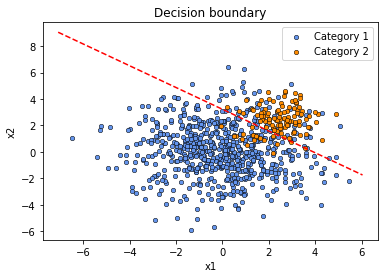

In [15]:
show_decision_boundary(final_slope,final_intercept)

### Solution 2 A: Undersampling: Let's use the original loss but with less samples from category 1
(This solution is in most cases not really recommended as valuable original samples will be thorwn away)


In [16]:
undersampled_data=xdata[xdata['category']==majority_class_flag].sample(n=num_minority_class,random_state=42)
undersampled_data=undersampled_data.append(xdata[xdata['category']==minority_class_flag])

data=undersampled_data.copy()
y=data.pop('category')
X=data
x_train_u, x_eval_u, y_train_u, y_eval_u = train_test_split(X,y,test_size=0.3, random_state = 42)


In [17]:

# the original eval set is used for predictions!
# using the original loss!
final_slope,final_intercept,eval_predictions=train(hinge_loss_svm,x_train_u,y_train_u,x_eval)


loss: [242.25392] slope: -1.8260705 intercept: 0.21821226 W 22.928854 41.869705 b 5.003357
loss: [38.805634] slope: -1.8253247 intercept: 0.67387736 W 8.857614 16.16802 b 5.968945
loss: [5.4157696] slope: -1.7507918 intercept: 2.0608475 W 3.2709212 5.726702 b 6.74087
loss: [1.077882] slope: -1.4180286 intercept: 4.6271353 W 1.4737334 2.089796 b 6.819164
loss: [0.88678706] slope: -1.0729805 intercept: 4.0601497 W 1.4948069 1.6038986 b 6.06914
loss: [0.75822103] slope: -1.0087004 intercept: 3.8215892 W 1.3976635 1.4098237 b 5.3412957
loss: [0.6483752] slope: -0.97429174 intercept: 3.644125 W 1.2808146 1.2478871 b 4.6674485
loss: [0.5578897] slope: -0.9777708 intercept: 3.5525796 W 1.1425582 1.1171601 b 4.059029
loss: [0.48412365] slope: -0.9526251 intercept: 3.3876784 W 1.0356946 0.98662865 b 3.5086002
loss: [0.42593664] slope: -0.93297774 intercept: 3.233659 W 0.93420017 0.87158793 b 3.0208848
loss: [0.3843056] slope: -0.94515675 intercept: 3.1319993 W 0.83315915 0.787466 b 2.609454
los

#### Of course, the classification report is done on the original eval set!

In [18]:
print(classification_report(y_eval, eval_predictions, target_names=['Category 1','Category 2']))

              precision    recall  f1-score   support

  Category 1       0.99      0.82      0.90       307
  Category 2       0.40      0.95      0.56        38

   micro avg       0.84      0.84      0.84       345
   macro avg       0.70      0.89      0.73       345
weighted avg       0.93      0.84      0.86       345



<p style="color:green">With undersampling we have similar results as with the weighted loss, and now we used the original loss. </p>
So this means, just by undersampling we could reach a better result!<br/>
Lets draw the decision boundary:

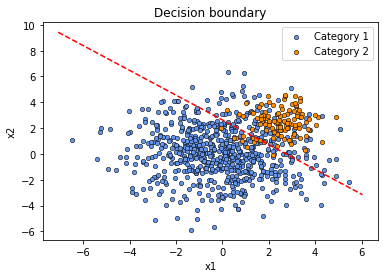

In [22]:
show_decision_boundary(final_slope,final_intercept)


### Solution 2 B: Oversampling: Let's use the original loss but with more samples from category 2


In [ ]:
all_minority_samples=xdata[xdata['category']==minority_class_flag]
oversampled_data=xdata.append(all_minority_samples)

data=undersampled_data.copy()
y=data.pop('category')
X=data
x_train_u, x_eval_u, y_train_u, y_eval_u = train_test_split(X,y,test_size=0.3, random_state = 42)